In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pesq import pesq
import pystoi
import pandas as pd

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance

from sound import Sound

2023-11-02 19:21:00.946164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
base_shape_size = 8192
ws = 255
ol = 128

In [4]:
sound_base = Sound('../../Dados/Base/', '../../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:08<00:00, 226.05it/s]


In [5]:
def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    stft_result = librosa.stft(signal, n_fft=window_size, hop_length=overlap)
    
    magnitude, phase = librosa.magphase(stft_result)
    phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(stft_result.shape[1]), sr=sampling_rate, hop_length=overlap)

    return magnitude, phi, f, t

def reconstruct_signal_from_stft(magnitude, phi, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    complex_spec = magnitude * np.exp(1j * phi)
    signal = librosa.istft(complex_spec, hop_length=overlap)

    return signal

def stft_to_signal(stft, sampling_rate=8000, window_size=ws, overlap=ol):
    A = stft[..., 0]
    phi = (stft[..., 1] - 0.5) * 2 * np.pi
    signal = reconstruct_signal_from_stft(A, phi, sampling_rate=sampling_rate, window_size=window_size, overlap=overlap)

    return signal

In [6]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files

        self.MIN_NOISE_LEVEL = 0.
        self.MAX_NOISE_LEVEL = 20
        self.MIN_WHITE_GAUSS_LEVEL = 15.
        self.MAX_WHITE_GAUSS_LEVEL = 25.

    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []
            x_snr_train = []
            metrics_data = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                # noisy_sound = somar_sinais(sound, noise, sr)
                min_valor = np.min(sound)
                max_valor = np.max(sound)
                
                # Defina o novo intervalo desejado
                novo_min = -0.4
                novo_max = 0.4
                
                # Realize a escala do sinal para o novo intervalo
                sound_escalado = (sound - min_valor) / (max_valor - min_valor) * (novo_max - novo_min) + novo_min

                sr = np.random.randint(self.MIN_NOISE_LEVEL, self.MAX_NOISE_LEVEL)
                noisy_sound = somar_sinais(sound_escalado, noise, sr)

                sr_gauss = float(np.random.randint(self.MIN_WHITE_GAUSS_LEVEL, self.MAX_WHITE_GAUSS_LEVEL))
                noisy_sound = add_white_gaussian_noise(noisy_sound, sr_gauss)
                noisy_sound = np.clip(noisy_sound, -1.0, 1.0)

                # Calcula a nota PESQ
                try:
                    pesq_score = pesq(8000, sound_escalado, noisy_sound.reshape(-1), 'nb')
                except:
                    continue
                
                # Calcula o score STOI
                stoi_score = pystoi.stoi(sound_escalado, noisy_sound, 8000)
                
                # Calcula SNR
                snr = calculate_snr(sound_escalado, noisy_sound)

                # Calcula o ID
                ID = itakura_distortion(sound_escalado, noisy_sound, 256, 11)
                
                metrics_data.append([sr, sr_gauss, pesq_score, stoi_score, snr, ID])
                
                A, phi, _, _ = calculate_stft_magnitude_and_phase(sound_escalado)
                A_noisy, phi_noisy, _, _ = calculate_stft_magnitude_and_phase(noisy_sound)

                # 1. Calcule a magnitude do ruído em cada frame
                Mag_ruido = np.abs(A - A_noisy)

                # 2. Calcule a SNR para cada frame
                P_sinal = np.sum(A**2, axis=0)
                P_ruido = np.sum(Mag_ruido**2, axis=0)
                SNR = 10 * np.log10(P_sinal / P_ruido)
                SNR = SNR.reshape(1, SNR.shape[0], 1)
                
                # Monta o fasor normalizando a faze por Pi
                F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), (phi.reshape(phi.shape[0], phi.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                F_noisy = np.concatenate([A_noisy.reshape(A_noisy.shape[0], A_noisy.shape[1], 1), (phi_noisy.reshape(phi_noisy.shape[0], phi_noisy.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(F_noisy)
                y_train.append(F)
                x_snr_train.append(SNR)

            x_train = np.array(x_train)
            y_train = np.array(y_train)
            x_snr_train = np.array(x_snr_train)
            metrics_df = pd.DataFrame(metrics_data, columns=['SNR Ruído aditivo', 'SNR Ruído Gauss Branco', 'PESQ', 'STOI', 'SNR', 'ID'])

            yield (x_train, x_snr_train), y_train, metrics_df

In [7]:
data_generator = DataGenerator(sound_base.train_X, sound_base.noise_sounds)

In [8]:
def process_batch(x_batch, y_batch, model):
    stfts = model.predict(x_batch, verbose=False)
    M, height, width, channels = stfts.shape  # Obtenha as dimensões do array de resultados do modelo

    pesq_scores = []
    stoi_scores = []
    snr_scores = []
    ID_scores = []

    for i in range(M):
        filtered = stfts[i, :, :, :]  # Obtenha o resultado do modelo para a iteração atual

        clean = y_batch[i, :, :, :]  # Obtenha o sinal limpo correspondente

        clean_signal = stft_to_signal(clean).reshape(-1)
        filtered_signal = stft_to_signal(filtered).reshape(-1)

        pesq_score = pesq(8000, clean_signal, filtered_signal, 'nb')
        stoi_score = pystoi.stoi(clean_signal, filtered_signal, 8000)
        snr_score = calculate_snr(clean_signal, filtered_signal)
        ID_score = itakura_distortion(clean_signal, filtered_signal, 256, 11)

        pesq_scores.append(pesq_score)
        stoi_scores.append(stoi_score)
        snr_scores.append(snr_score)
        ID_scores.append(ID_score)

    return pesq_scores, stoi_scores, snr_scores, ID_scores

In [9]:
batch_num = 50
df_resultado = pd.DataFrame()

In [10]:
model = load_model('unet-snr-STFT-30-epochs-2023-11-02_19-12-54.h5')

2023-11-02 19:21:12.497591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 19:21:12.501970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 19:21:12.502130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
results = []

for _ in tqdm(range(batch_num)):
    x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_completo(batch_size=128))
    results.append((process_batch(x_batch, y_batch, model),metrics_batch_df))

df_resultado = pd.DataFrame()

for result , metrics_batch_df in results:
    pesq_scores, stoi_scores, snr_scores, ID_scores = result
    metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    metrics_batch_df['STOI (Filtered)'] = stoi_scores
    metrics_batch_df['SNR (Filtered)'] = snr_scores
    metrics_batch_df['ID (Filtered)'] = ID_scores
    
    df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

100%|██████████| 50/50 [12:03<00:00, 14.46s/it]


In [12]:
df_resultado

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
0,6,20.0,1.816645,0.911597,5.826894,0.178325,2.389961,0.911896,5.717461,0.327009
1,3,21.0,1.658701,0.791187,2.879854,0.911803,2.515446,0.851815,6.764100,-0.019608
2,14,23.0,2.060731,0.949476,13.504570,0.022707,2.850811,0.954383,9.669465,0.228165
3,8,24.0,1.826938,0.720323,7.868097,-0.049620,2.230948,0.689825,5.774770,-0.346990
4,16,16.0,1.787567,0.872400,12.942564,-0.039887,2.800806,0.895637,7.263418,0.121866
...,...,...,...,...,...,...,...,...,...,...
6393,4,21.0,1.836512,0.784710,3.885001,-0.038238,2.190738,0.787385,4.001876,-0.240097
6394,17,20.0,2.395407,0.956476,15.301195,0.243325,2.778161,0.945024,11.280614,0.139097
6395,17,22.0,1.877450,0.925216,15.784895,0.058767,2.638884,0.935889,10.137689,0.036049
6396,1,23.0,1.355526,0.680591,0.954540,0.737312,1.454207,0.782767,5.732546,-0.196488


In [13]:
df_resultado.describe()

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
count,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000
mean,9.534855,19.447015,1.886933,0.813182,8.626122,-0.014692,2.547483,0.844508,7.387105,-0.021354
std,5.785274,2.855587,0.440611,0.125849,5.014855,0.384869,0.508033,0.108219,2.387997,0.254884
min,0.000000,15.000000,1.066404,0.142082,-0.306609,-2.024775,1.101916,0.068536,-0.590902,-1.676047
25%,5.000000,17.000000,1.556013,0.742768,4.463775,-0.243745,2.178565,0.797290,5.579084,-0.173579
50%,9.000000,19.000000,1.818150,0.839459,8.844374,-0.004990,2.560791,0.871871,7.335915,-0.016310
75%,15.000000,22.000000,2.146449,0.910235,12.921094,0.222103,2.910388,0.922142,9.216483,0.139539
max,19.000000,24.000000,4.276752,0.998969,17.882330,1.707171,3.922302,0.990177,13.889970,1.022972


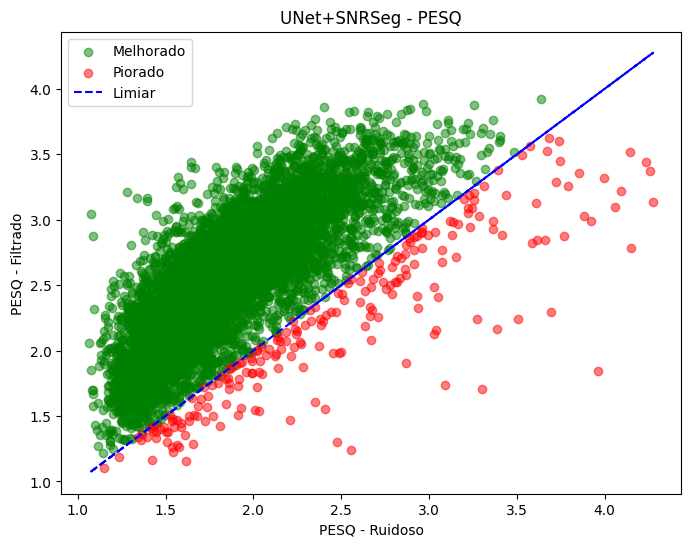

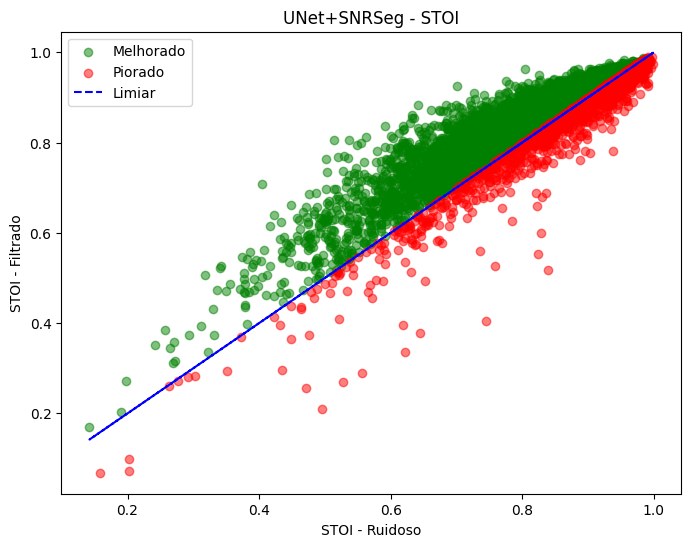

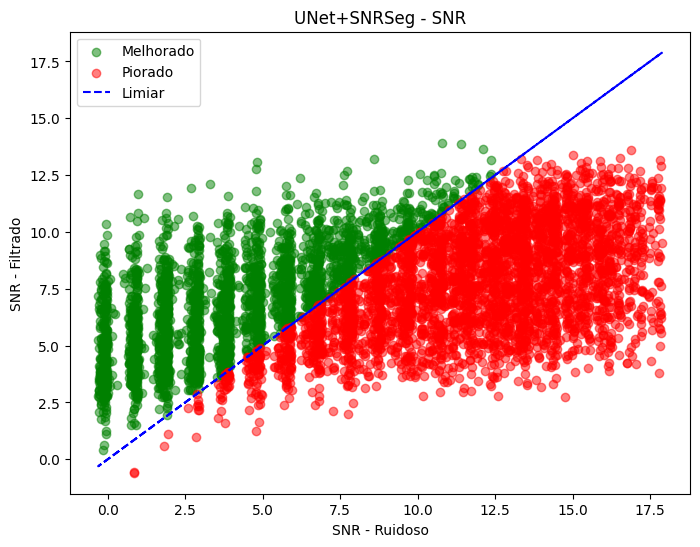

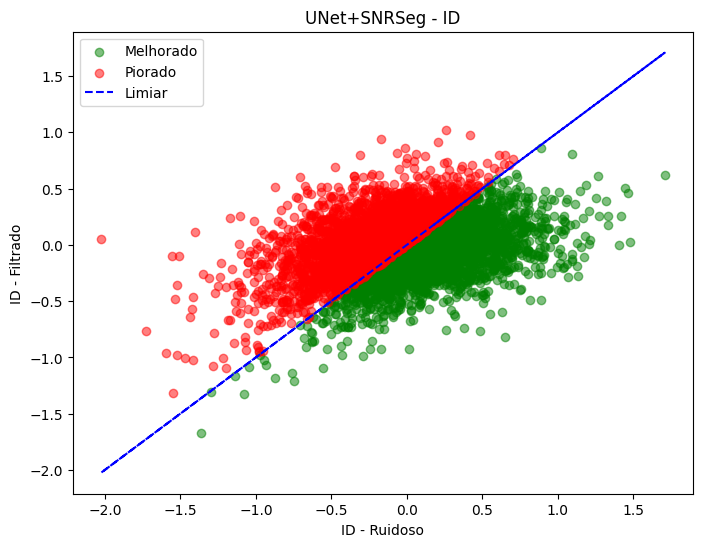

In [15]:
performance(df_resultado, 'UNet+SNRSeg')